In [76]:
suppressPackageStartupMessages({
    library(Matrix)
    library(ggplot2)
    library(cygnus)
    library(dplyr)
    library(data.table)
    library(purrr)
    library(ggthemes)
    library(viridis)
    library(patchwork)
    library(glue)
    library(sf)
    library(ComplexHeatmap)
    library(RSpectra)
    library(mclust)
    library(Seurat)
    library(DESeq2)
    })

fig.size <- function(w,h) {
    options(repr.plot.height = h, repr.plot.width = w)
}

In [54]:
aggs1 = readRDS("../outputs/aggs1.rds")
metadata = aggs1$meta_data
dmt1 = readRDS('../outputs/dmt1.rds')
genes = read.table('../data/VizgenLungHacohen/cells/genes.txt')
merge_metadata = read.csv('../data/p1_merge_metadata.csv', row.names=1, header=TRUE)

In [55]:
# Input unnormalized counts into DESeq as required by the package instructiondim(counts_data)
meta = merge_metadata
macrophage_type = c('MARCO+ Macrophage', 'SPP1+ Macrophage', 'FOLR2+CD14+ Macrophage', 'MERTK+ Macrophage',
                   'FCN1+LYZ+ Macrophage', 'CXCL10+ Macrophage', 'PLA2G7+ CCL18+ Macrophage')
meta = subset(meta, type_lvl2 %in% macrophage_type)
head(meta)
# Cell-level gene counts data 
counts_data = dmt1$counts[,as.integer(rownames(meta))] # For just macrophag, using cell index
# Help solve the error with DESeq2
# Every gene contains at least one zero, cannot compute log geometric means

counts_data = counts_data + 1
row.names(counts_data) = genes$V1

# Getting just the macrophage


,ORIG_ID,X,Y,type_lvl1,type_lvl2,f,agg_id,spatial_cluster,hubID,hubType
,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>
15,16,7099.507,68.97765,Myeloid,MARCO+ Macrophage,1.569256,2,0,H260,tumor
18,19,7088.350,24.30018,Myeloid,MARCO+ Macrophage,1.649435,3832,1,H260,tumor
62,64,7107.079,226.44103,Myeloid,MARCO+ Macrophage,1.591024,4,13,H260,tumor
65,67,7088.810,252.27786,Myeloid,SPP1+ Macrophage,1.209664,4,13,H260,tumor
152,363,7117.578,961.20624,Myeloid,FOLR2+CD14+ Macrophage,1.575812,412,9,H260,tumor
155,366,7113.570,972.08289,Myeloid,MERTK+ Macrophage,1.325431,412,9,H260,tumor


In [56]:
# What are the percentage of each macrophage subtypes in each spatial cluster?
round(table(meta['spatial_cluster']) / dim(meta)[1], 2)

spatial_cluster
   0    1    2    3    4    5    6    7    8    9   10   11   12   13 
0.15 0.03 0.02 0.04 0.10 0.23 0.10 0.10 0.16 0.04 0.01 0.01 0.00 0.01 

In [217]:
plot_contingency <- function(df, col1, col2, normalized_by=NULL, title='Contingency table',
                            annot=TRUE, xlabel='', ylabel=''){
    # Contigency between macrophage type and hubType
    contingency_table = table(meta[,c(col1, col2)])
    contingency = matrix(contingency_table, nrow=dim(unique(meta[col1])[1]))
    if (!is.null(normalized_by)){
        if (normalized_by=='row'){
        contingency = sweep(contingency, 1, rowSums(contingency), "/")
        }
        if (normalized_by == 'col'){
            contingency = sweep(contingency, 2, colSums(contingency), "/")
        }
    }
    
    
    colnames(contingency) <- colnames(contingency_table)
    row.names(contingency) <- rownames(contingency_table)
    contingency_melt = melt(contingency)
    contingency_melt$Var2 = as.factor(contingency_melt$Var2)
    
    p = ggplot(contingency_melt, aes(x=Var2, y=Var1, fill=value)) +
        geom_tile() +
        scale_fill_gradient(low='white', high='blue') +
        theme_minimal() +
        theme(axis.text.x = element_text(angle=90, hjust=1)) +
        labs(x=xlabel, y=ylabel, title=title, fill='Value') +
        scale_x_discrete(breaks = unique(contingency_melt$Var2))

    if (annot){
        p = p + geom_text(aes(label = round(value, 2)), size = 4) 
    }
    return(p)
}


Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(contingency). In the next version, this warning will become an error.”


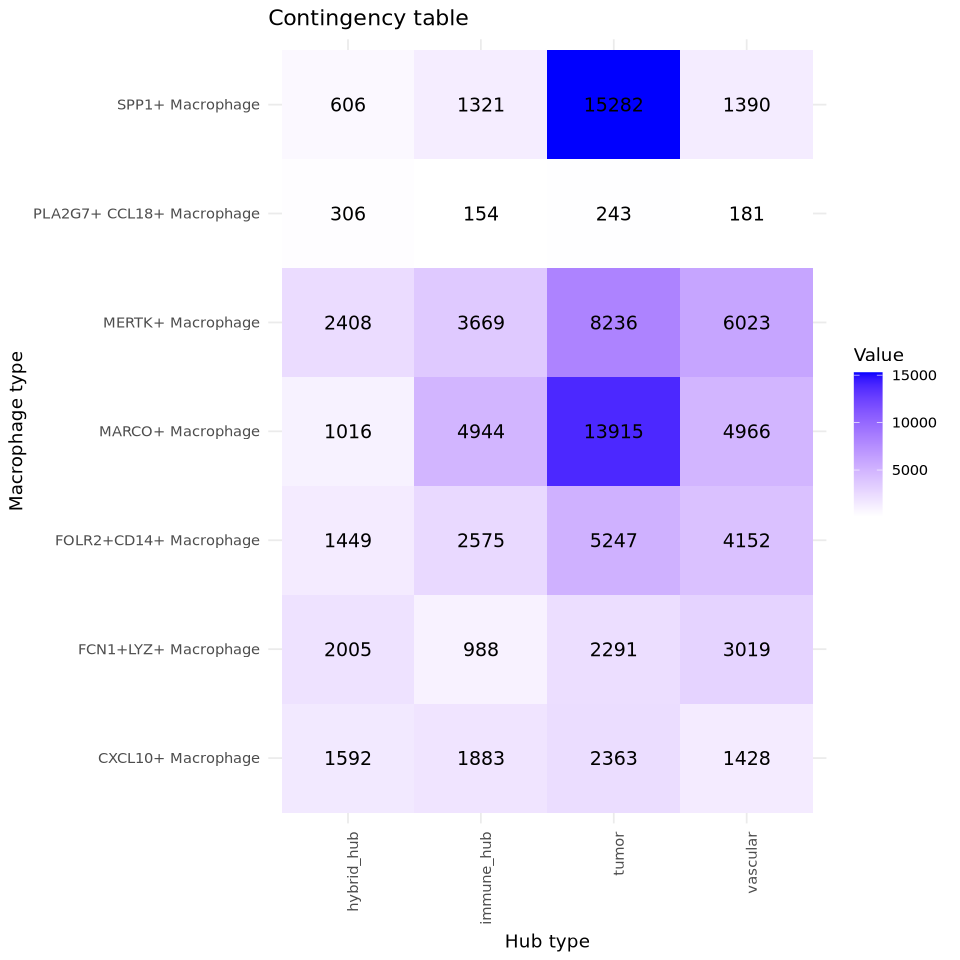

In [218]:
fig.size(8,8)
plot_contingency(meta, 'type_lvl2', 'hubType', ylabel='Macrophage type', xlabel='Hub type')

Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(contingency). In the next version, this warning will become an error.”


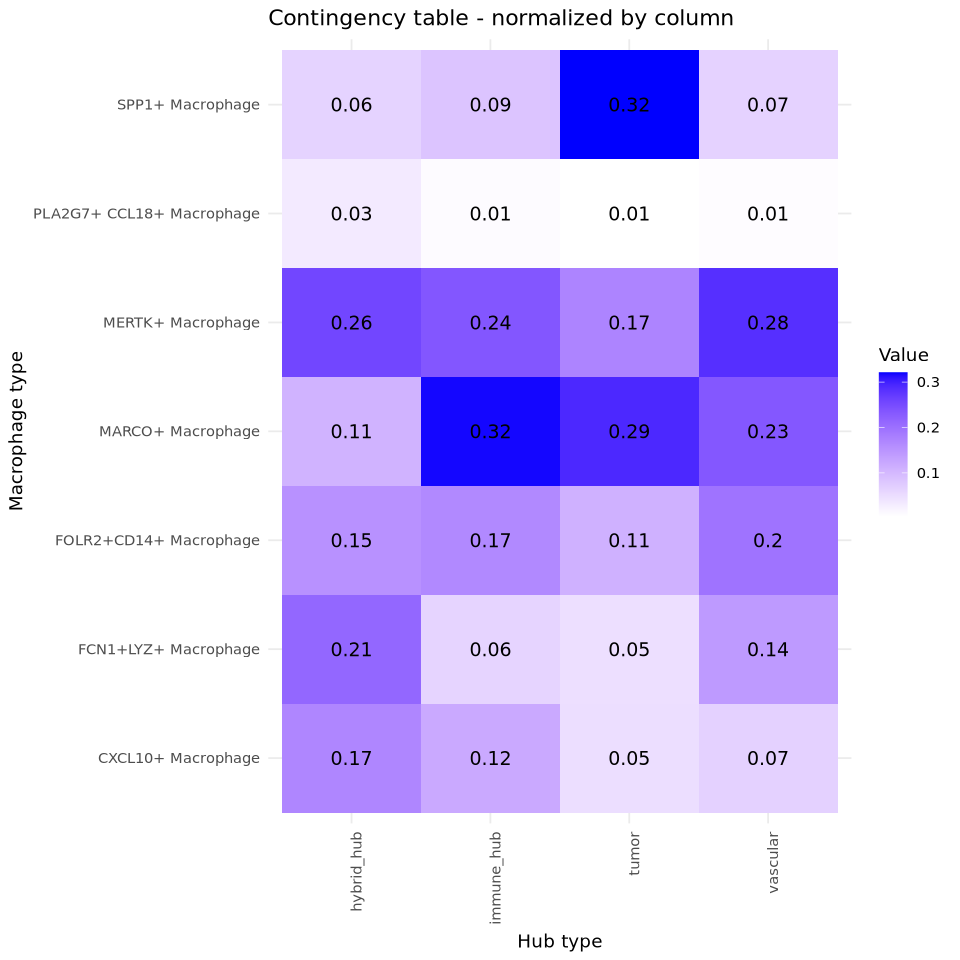

In [219]:
plot_contingency(meta, 'type_lvl2', 'hubType', normalized_by='col', 
                 ylabel='Macrophage type', xlabel='Hub type',title='Contingency table - normalized by column')

Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(contingency). In the next version, this warning will become an error.”


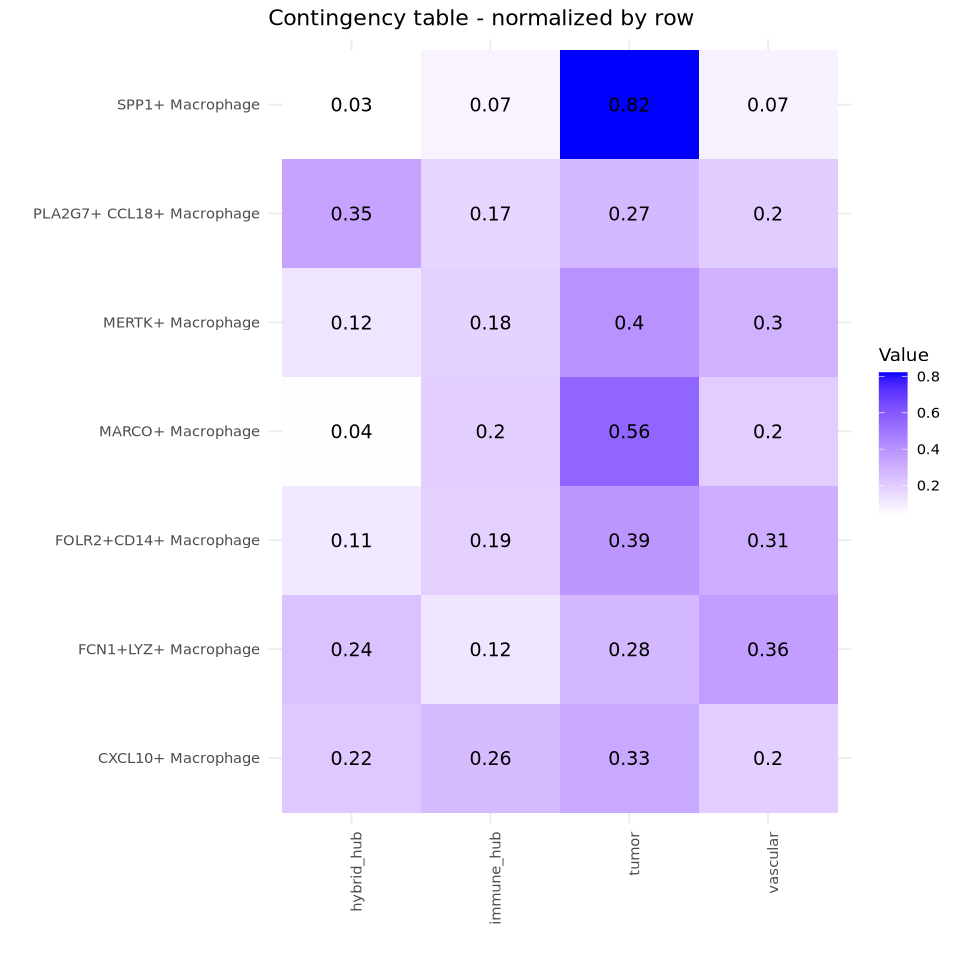

In [220]:
plot_contingency(meta, 'type_lvl2', 'hubType', normalized_by='row', title='Contingency table - normalized by row')

Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(contingency). In the next version, this warning will become an error.”


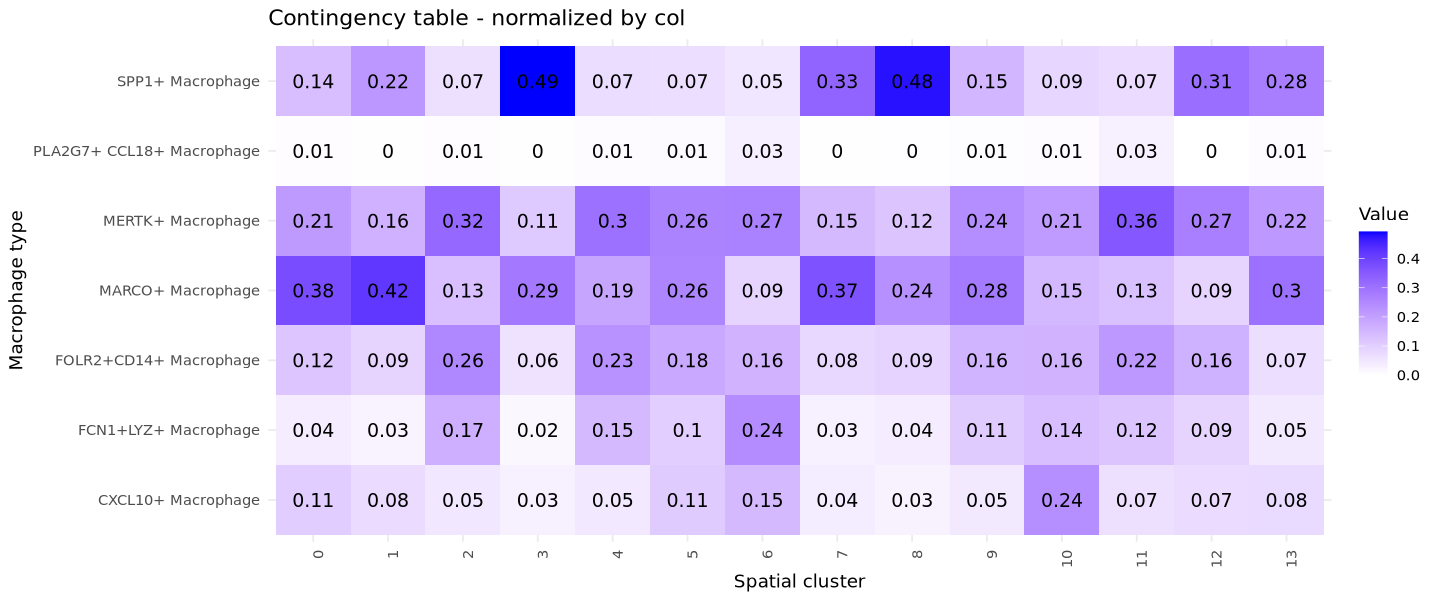

In [222]:
fig.size(12,5)
p = plot_contingency(meta, 'type_lvl2', 'spatial_cluster', normalized_by='col',
                     ylabel='Macrophage type', xlabel='Spatial cluster', 
                    title='Contingency table - normalized by col') 
p

## DESeq based on hubType

In [57]:
dds <- DESeqDataSetFromMatrix(countData=counts_data, colData=meta, design= ~ 0 + hubType)
dds <- DESeq(dds)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [60]:
saveRDS(dds, file='../outputs/macrophage_deseq2.RDS')

In [64]:

create_contrast <- function(c, total=4){
    arr = rep(-1/(total-1), times = total)
    arr[c] = 1
    return(arr)
}
# Name according to dds$hubType order
hubnames = c('hybrid_hub', 'immune_hub', 'tumor', 'vascular')
res = c()
full_result = c()
clusters = as.character(seq(1:4))
for (i in 1:length(clusters)){
  deseq2results <- results(dds, contrast=create_contrast(i, length(clusters)))
  top_ten = deseq2results[order(deseq2results$log2FoldChange, decreasing=TRUE),][1:10,]
  top_ten$hubType = hubnames[i]
  res <- rbind(res, top_ten)
  full_res = deseq2results[order(deseq2results$log2FoldChange, decreasing=TRUE),]
  full_res$hubType = hubnames[i]
  full_result <- rbind(full_res)
  
}


In [70]:
saveres = full_result %>% data.frame() %>% View()
write.table(saveres, file='../outputs/macrophageDE_fullres.csv')


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,hubType
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
COL4A1,1.686826,0.11128955,0.011136982,9.992793,1.638976e-23,5.127655e-22,vascular
LYZ,1.482670,0.09748940,0.009986857,9.761770,1.642628e-22,4.496694e-21,vascular
IL7R,1.133782,0.06067940,0.011086774,5.473134,4.421460e-08,5.096314e-07,vascular
C1QB,1.290549,0.05111133,0.010338060,4.943996,7.653734e-07,7.618944e-06,vascular
CXCL9,1.116216,0.05047859,0.011153512,4.525802,6.016686e-06,4.880201e-05,vascular
C1QA,1.301904,0.05003055,0.010298012,4.858273,1.184140e-06,1.127508e-05,vascular
TIMP1,1.118660,0.04694613,0.011180179,4.199050,2.680375e-05,2.024145e-04,vascular
ARHGDIB,1.256636,0.04618224,0.010465049,4.412998,1.019487e-05,7.973848e-05,vascular
MRC1,1.398772,0.04534230,0.009866803,4.595440,4.318368e-06,3.782891e-05,vascular


In [67]:
test <- results(dds, contrast=c('hubType', 'tumor', 'immune_hub'))
test[order(test$log2FoldChange, decreasing=TRUE),]

log2 fold change (MLE): hubType tumor vs immune_hub 
Wald test p-value: hubType tumor vs immune_hub 
DataFrame with 479 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
ANXA1      2.40860       0.262790 0.0114541   22.9429 1.73469e-116 1.25765e-114
MET        1.58245       0.241554 0.0110397   21.8805 3.98865e-106 1.92785e-104
EFNB2      1.64320       0.220843 0.0108501   20.3540  4.27886e-92  1.03406e-90
LY6E       1.68447       0.209343 0.0105938   19.7609  6.45867e-87  1.33787e-85
SERPINA1   1.45308       0.158580 0.0113934   13.9185  4.88748e-44  8.85856e-43
...            ...            ...       ...       ...          ...          ...
CD74       6.88713      -0.137171 0.0120088  -11.4225  3.22780e-30  3.90026e-29
CD163      1.85081      -0.144622 0.0108574  -13.3201  1.76917e-40  2.85032e-39
ACTA2      1.33490      -0.240758 0.0112541  -21.3929 1.55733

In [260]:
test[order(test$log2FoldChange, decreasing=TRUE),][1:10,]

log2 fold change (MLE): hubType tumor vs hybrid_hub 
Wald test p-value: hubType tumor vs hybrid_hub 
DataFrame with 10 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat      pvalue        padj
         <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
SPP1       1.33599      0.1897765 0.0155446  12.20855 2.79822e-34 3.73103e-33
LCN2       1.26126      0.1239340 0.0147024   8.42951 3.47130e-17 3.04086e-16
IGFBP3     1.20368      0.1094263 0.0151187   7.23780 4.56005e-13 3.32883e-12
LY6E       1.68447      0.0920550 0.0125792   7.31802 2.51656e-13 1.90043e-12
EGR1       1.67303      0.0830652 0.0135377   6.13584 8.47084e-10 4.63779e-09
EPHA2      1.09787      0.0684518 0.0158152   4.32822 1.50319e-05 6.09628e-05
PLTP       1.36167      0.0557194 0.0140523   3.96515 7.33494e-05 2.76957e-04
SERPINA1   1.45308      0.0456583 0.0135305   3.37447 7.39569e-04 2.41740e-03
SOX4       1.22891      0.0432405 0.0148023   2.92121 3.48678e-03 1.03190e-02
MET 

In [72]:
str(dds)

Formal class 'DESeqDataSet' [package "DESeq2"] with 8 slots
  ..@ design            :Class 'formula'  language ~0 + hubType
  .. .. ..- attr(*, ".Environment")=<environment: R_GlobalEnv> 
  ..@ dispersionFunction:function (means)  
  .. ..- attr(*, "fitType")= chr "local"
  .. ..- attr(*, "varLogDispEsts")= num 0.273
  .. ..- attr(*, "dispPriorVar")= num 0.273
  ..@ rowRanges         :Formal class 'CompressedGRangesList' [package "GenomicRanges"] with 5 slots
  .. .. ..@ unlistData     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. ..@ values         : Factor w/ 0 levels: 
  .. .. .. .. .. .. ..@ lengths        : int(0) 
  .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. .. .. ..@ start          : int(0) 
  .. .. .. .. 

# DESeq with spatial_cluster instead of hubType

In [74]:
dds2 <- DESeqDataSetFromMatrix(countData=counts_data, colData=meta, design= ~ 0 + spatial_cluster)
dds2 <- DESeq(dds2)

converting counts to integer mode

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [75]:
saveRDS(dds2, file='../outputs/macrophage_deseq2_spatialcluster.RDS')

In [ ]:
# Check cluster order within dds2

In [ ]:

create_contrast <- function(c, total=4){
    arr = rep(-1/(total-1), times = total)
    arr[c] = 1
    return(arr)
}
# Name according to dds$hubType order
hubnames = c('hybrid_hub', 'immune_hub', 'tumor', 'vascular')
res = c()
full_result = c()
clusters = as.character(seq(1:4))
for (i in 1:length(clusters)){
  deseq2results <- results(dds, contrast=create_contrast(i, length(clusters)))
  top_ten = deseq2results[order(deseq2results$log2FoldChange, decreasing=TRUE),][1:10,]
  top_ten$hubType = hubnames[i]
  res <- rbind(res, top_ten)
  full_res = deseq2results[order(deseq2results$log2FoldChange, decreasing=TRUE),]
  full_res$hubType = hubnames[i]
  full_result <- rbind(full_res)

}


In [ ]:
saveres = full_result %>% data.frame() %>% View()
write.table(saveres, file='../outputs/macrophageDE_fullres.csv')


In [ ]:
test <- results(dds, contrast=c('hubType', 'tumor', 'immune_hub'))
test[order(test$log2FoldChange, decreasing=TRUE),]

In [ ]:
test[order(test$log2FoldChange, decreasing=TRUE),][1:10,]

In [ ]:
str(dds)

# DESeq with spatial_cluster instead of hubType

In [ ]:
dds2 <- DESeqDataSetFromMatrix(countData=counts_data, colData=meta, design= ~ 0 + spatial_cluster)
dds2 <- DESeq(dds2)

In [ ]:
saveRDS(dds2, file='../outputs/macrophage_deseq2_spatialcluster.RDS')

In [ ]:
res = c()
full_result = c()
clusters = as.character(seq(1:4))
for (i in 1:length(clusters)){
  deseq2results <- results(dds, contrast=create_contrast(i, length(clusters)))
  top_ten = deseq2results[order(deseq2results$log2FoldChange, decreasing=TRUE),][1:10,]
  top_ten$hubType = hubnames[i]
  res <- rbind(res, top_ten)
  full_res = deseq2results[order(deseq2results$log2FoldChange, decreasing=TRUE),]
  full_res$hubType = hubnames[i]
  full_result <- rbind(full_res)

}}